In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lmfit import minimize, Parameters
import sys
sys.path.append(r'C:\Users\Jack Halliday\Documents\MagPy')
%matplotlib notebook
plt.style.use('jackhal')

In [2]:
from MagPy.Spectrometry import Spectrometer, Bundle, Spectrum
from MagPy.Ionisation import IaeaTable
from MagPy.Thomson import S_k_omega

In [3]:
shot_spectrometer = Spectrometer('s0903_20 TS shot.asc')
background_spectrometer = Spectrometer('bk.asc')
bundle = Bundle()

# Split up the Spectrometer's CCD image into a spectrum for each fiber

Adjust the variables in the cell below, rerunning the code with each adjustment, until the split shown in the plot is good.

In the plot, the blue box corresponds to the size of the window taken to calculate dark count. 

The red boxes are the region to be used for the spectrum of each fiber.

Once you're happy with the output, run the next cell to perform the split.

In [4]:
bundle.sp=17.9    # The spacing between fiber centres (in pixels)
bundle.off=7.7    # The position of the centre of the uppermost fiber (in pixels)
bundle.dis=2      # The number of pixels to ignore between each fiebr
bundle.l0=531.     # The wavelength (in nm) of the LH side of the red boxes 
bundle.l1=532.5     # The wavelength (in nm) of the RH side of the red boxes
bundle.dl = 528.  # The wavelength (in nm) of the LH side of the blue box (used to calculate dark count)
bundle.dw = 1.5    # The width (in nm) of the blue box (used to calculate dark count)


bundle.draw_split(shot_spectrometer)

<IPython.core.display.Javascript object>

In [5]:
bundle.split(shot_spectrometer, background_spectrometer) # Do the split & populate bundle.fibers

# Specify the ionisation model 
The code in the next cell assumes a function named $z\_model(T_e[eV], n_e[cm^{-3}])$. 
Here we call a class to create this function by linearly interpolating over tabulated data which was generated using the atomic code FLYCHK. 

Set the Variable atomic number to a value relevant to your experiment.

In [6]:
atomic_number = 14
tabulated_data = IaeaTable(atomic_number)
z_model = tabulated_data.model

# Define a fitting model
This code defines a model which takes plasma parameters, a Spectrum object, and an ionisation model and returns a value for the intensity of scattered light  

In [7]:
def ThomsonModel(params, spectrum, z_model, atomic_number, theta):
    # Set things up:
    Te = params['Te']   # Electron Temp [eV]
    Ti = params['Ti']   # Ion Temp [eV]
    ne = params['ne']   # Electron density [cm^-3]
    vi = params['vi']   # Ion speed [m/s]
    vd = params['vd']   # Electron drift speed [m/s]
    stray_amp = params['stray_amp'] # Intensity of stray light [Arb]
    amp = params['amp'] # Intensity of Thomson signal [Arb]
    se_amp = params['self_emission'] # Intensity of constant offset from self emission [Arb]
    
    l = spectrum.l      # Spectral subgird (upon which scattering model calculated) [nm]
    l0 = spectrum.get_probe_wavelength() # Probe wavelength [nm]
    y_data = spectrum.s_y     # Shot Intensity data from the spectrum object
    y_error = spectrum.s_yerr # Shot Intensity error from the spectrum object
    y_se = spectrum.y_se 
    y_stray = spectrum.y_stray
    
    # Where the physics lives:
    Z = z_model(Te, ne)       # Ionisation model 
    S, alpha = S_k_omega(l, l0, theta, atomic_number, Te, Ti, ne, Z, vi, vd) # Calculate spectral density on subgrid scale
    model = spectrum.convolve_fixed_grid(S) # Calculate convolution with response, return values on subgrid
    model *= amp/model.max() # Scale spectrum by fit-amplitude
    model += stray_amp*y_stray # Add contribution from srtay light
    model += se_amp*y_se # Add contribuiton from self-emission
    return model, alpha

# Define a function to calculate the residual, and one to plot fitted data

In [8]:
def Residual(params, spectrum, model, **kwargs):
    m = model(params, spectrum, **kwargs)[0]
    m = spectrum.downsample_to_data_grid(m) 
    y_data = spectrum.s_y
    y_error = spectrum.s_yerr
    residual = (y_data-m)**2
    return residual

def Plot(ax, params, spectrum, model, **kwargs):
    l0 = spectrum.get_probe_wavelength()
    dl = 0.35
    x1 = dl
    x0 = -dl
    ax.set_xlim(x0, x1)
    
    x_data = spectrum.s_l
    y_data = spectrum.s_y
    y_error = spectrum.s_yerr
    x_fit = spectrum.l
    y_fit, alpha = model(params, spectrum, **kwargs)
    
    y0 = 0
    y1 = (y_data+y_error).max()*1.1
    ax.set_ylim(y0,y1)
    
    r_sc = 0.8*y_data.max()
    x_response = spectrum.l
    y_response = r_sc*spectrum.get_response(x_response)
    x_laser = spectrum.b_l
    y_laser = spectrum.b_y
    y_laser *= r_sc / y_laser.max()
    
    ax.plot(x_response-l0, y_response, label='Response', c='b', lw=1.5, ls='--', zorder=1)
    ax.scatter(x_laser-l0, y_laser, c='k', s=5, zorder=2)
    ax.errorbar(x_data-l0, y_data, yerr=y_error, xerr=0, color='k', \
                fmt='ko', label='Data', zorder=2, lw=1., ms=4, capsize=2)
    ax.plot(x_fit-l0, y_fit, zorder=1, c='r', label='Best Fit')
    ax.legend()
    
    ax.set_xlabel('$\Delta \lambda \; [nm]$')
    ax.set_ylabel('Intensity [Arb]')

# Select the spectrum from a particular fiber and prepare spectrum for fitting
1. Select the spectrum from the bundle by changing the key to match a fiber label from the plot above
2. Fit Voigt response to the background spectrum, and save fitting parameters internally to the spectrum object
3. Setup a fixed spectral grid onto which the the theoretical scattering spectrum should be calculated, along with a Voigt kernal (on the same grid) to be used for convolution. This grid may have to be finer than the data-grid, if the width of features in the spectrum are comparable to the separation of points in the data. The setup function takes 2 arguments:
	- **w_grid**: spacing between grid points as a fraction of the FWHM of the fitted instrument response. Value should be <= 1. Smaller values are more accurate but convolutions will be slower.
	- **w_kernal**: width of the kernel as a multiple the width of the computed kernel for convolution, as a  multiple of the FWHM of the instrument response. Value should be >= 1. Larger values will be more accurate but slower. 

In [34]:
fiber = bundle.fibers['9A'] # Select spectrum for a fiber
fiber.fit_response()        # Fit response to background data
fiber.setup_convolution_grid(w_grid=0.05, w_kernal=4.) # Setup fixed grid & a kernal for efficient convolution


# Finally, you can perform the fit

<IPython.core.display.Javascript object>


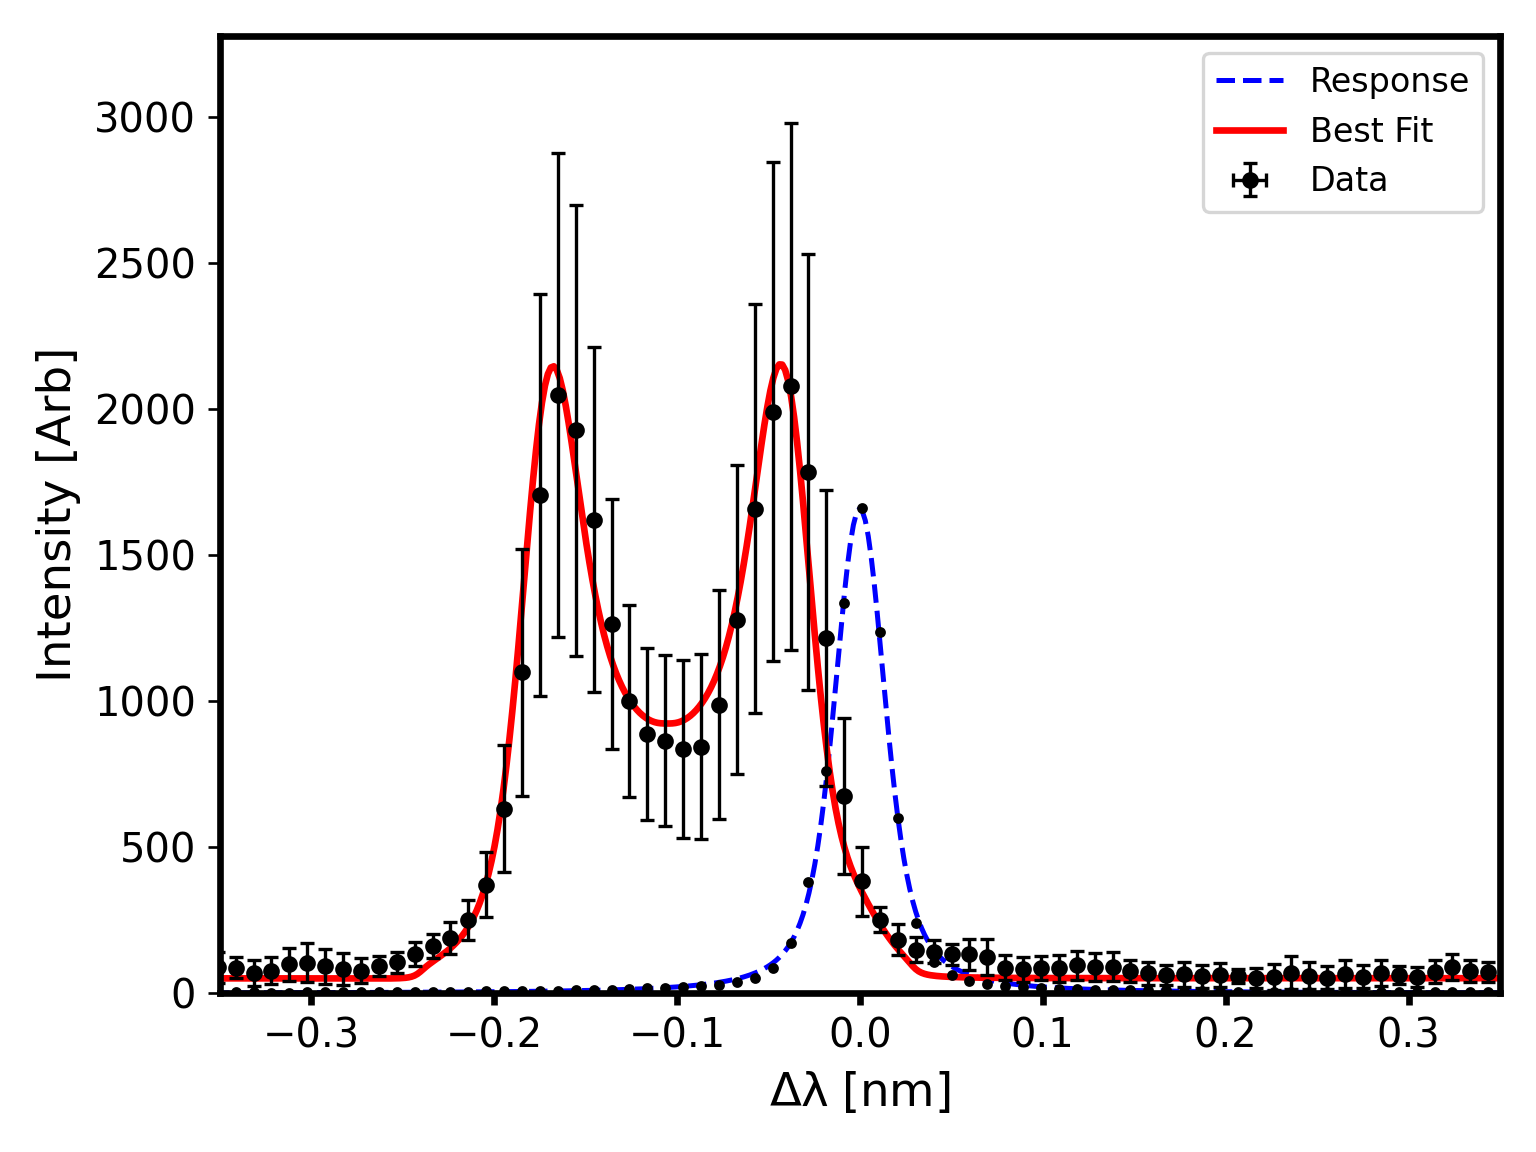

name,value,standard error,relative error,initial value,min,max,vary
Te,15.9869829,0.05408398,(0.34%),10.0,1.00000000,1000.00000,True
Ti,11.1926081,0.13635845,(1.22%),10.0,1.00000000,1000.00000,True
ne,1.0000e+18,0.00000000,(0.00%),1e+18,-inf,inf,False
vi,42143.2458,55.2318930,(0.13%),400000.0,-inf,inf,True
vd,0.00000000,0.00000000,,0.0,-inf,inf,False
amp,2095.71586,10.2809826,(0.49%),3500,-inf,inf,True
stray_amp,100.000000,0.00000000,(0.00%),100.0,0.00000000,inf,False
self_emission,50.0000000,0.00000000,(0.00%),50.0,0.00000000,inf,False


In [43]:
key_word_args = { 
    'model': ThomsonModel,
    'spectrum': fiber,
    'z_model': z_model,             # If you change atomic_number here then
    'atomic_number': atomic_number, # dont forget to update z_model also!! 
    'theta': 270.0,                 # Theta [degrees] specified here.
}
params = Parameters()
params.add('Te', value=10., min=1, max=1e3, vary=True)
params.add('Ti', value=10., min=1, max=1e3, vary=True)
params.add('ne', value=1e18, vary=False)
params.add('vi', value=4e5, vary=True)
params.add('vd', value=0., vary=False)
params.add('amp', value=3500, vary=True)
params.add('stray_amp', value=100., min=0., vary=False)
params.add('self_emission', value=50., min=0., vary=False)

out = minimize(Residual, params, kws=key_word_args, calc_covar=True)

fig, ax = plt.subplots()
Plot(ax, out.params, **key_word_args)
out.params